In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime

In [2]:
df=pd.read_csv('AUD_CAD.csv')

In [3]:
df

,Date,High,Low,Close,Volume,Price,Change In Price,Divergence Factor 1,Divergence Factor 2,Divergence Factor 3,...,% Rank of MF Avgs,RSI,MACD,WPCTR,CCI,CCI Percentile,PNL Percentile,pdi,mdi,adx
0,2011-04-27 16:00:00+00:00,1.03734,1.03026,1.03626,29386,1.03626,0.005632,0.077906,-0.807428,-0.024640,...,1.000000,72.047691,0.007988,-3.205699,160.220406,0.949147,0.885333,30.722378,15.987733,22.004646
1,2011-04-28 16:00:00+00:00,1.04454,1.03342,1.03744,21182,1.03744,0.001138,0.085797,-0.810703,-0.025421,...,0.000000,71.491990,0.008529,-17.363659,169.019291,0.958362,0.896500,34.720773,14.109004,23.447991
2,2011-04-29 16:00:00+00:00,1.03878,1.03580,1.03722,4697,1.03722,-0.000212,0.078517,-0.815983,-0.028258,...,0.500000,73.462912,0.008838,-17.901687,134.683097,0.899659,0.894500,33.581892,13.646213,24.788240
3,2011-04-30 16:00:00+00:00,1.03722,1.03722,1.03722,13,1.03722,0.000000,0.079358,-0.815142,-0.026154,...,0.000000,73.462912,0.008979,-17.901687,111.254362,0.832423,0.894500,33.581892,13.646213,26.032756
4,2011-05-01 16:00:00+00:00,1.04434,1.03460,1.04132,18473,1.04132,0.003945,0.079452,-0.841548,-0.025218,...,0.500000,74.119923,0.009315,-7.874786,112.320284,0.838567,0.921000,37.952153,12.137118,27.854563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2951,2020-08-28 16:00:00+00:00,0.96515,0.96242,0.96480,20503,0.96480,0.001213,-0.100462,-0.450295,-0.008374,...,0.705524,72.760827,0.001375,-1.560410,217.117331,1.000683,0.349833,32.571881,14.887937,23.137031
2952,2020-08-30 16:00:00+00:00,0.96526,0.96066,0.96296,113463,0.96296,-0.001909,-0.034379,-0.369046,-0.006945,...,0.595867,66.948285,0.002011,-10.204082,152.261247,0.935495,0.334667,30.654079,16.264114,23.675124
2953,2020-08-31 16:00:00+00:00,0.96436,0.95942,0.96188,160527,0.96188,-0.001122,0.010566,-0.315601,-0.006964,...,0.719269,63.586674,0.002401,-14.995563,110.137861,0.827986,0.326167,28.699769,16.827511,23.846703
2954,2020-09-01 16:00:00+00:00,0.96441,0.95512,0.95592,132780,0.95592,-0.006215,0.099448,-0.183219,-0.005336,...,0.803656,54.347826,0.002203,-41.437445,59.071660,0.664164,0.282667,25.417921,20.196158,22.961060


In [4]:
class TS_Uni_Models():
    
    def __init__(self,df,future_target,past_history):
        self.df=df
        self.future_target=future_target
        self.past_history=past_history
    
    def univariate_data(self,dataset, start_index, end_index, history_size, target_size):
        data = []
        labels = []
        start_index = start_index + history_size
        if end_index is None:
            end_index = len(dataset) - target_size
        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[indices], (history_size, 1)))
            labels.append(dataset[i+target_size])
        return np.array(data), np.array(labels)
    
    def CalMSE(self,actual,pred):
        return mean_squared_error(actual,pred)
    
    def Univariate_LSTM(self):
        df=self.df
        dataset = df
        len_dataset=len(dataset)
        BATCH_SIZE = 1
        BUFFER_SIZE = 1
        EVALUATION_INTERVAL =len_dataset//BATCH_SIZE
        EPOCHS =5
        univariate_past_history=self.past_history
        univariate_future_target = self.future_target
        STEP = 1
       
        x_train_uni, y_train_uni = self.univariate_data(uni_data, 0, None,univariate_past_history,univariate_future_target)
        #x_val_uni, y_val_uni =x_train_uni[0:1],y_train_uni[0:1]
        #x_train_uni,y_train_uni=x_train_uni[1:],y_train_uni[1:]
        train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
        train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
        #val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
        #val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
        
        simple_lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(150,input_shape=x_train_uni.shape[-2:]),
        #tf.keras.layers.LSTM(50,activation='relu',return_sequences=True),
        #tf.keras.layers.LSTM(50,activation='relu',return_sequences=True),
        #tf.keras.layers.LSTM(50,activation='relu'),
        tf.keras.layers.Dense(1)
        ])
        simple_lstm_model.compile(optimizer='adam', loss='mse')
        simple_lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL)
        #prediction=None
        #for x, y in val_univariate.take(1):
        #    prediction=simple_lstm_model.predict(x)
           # y=y.numpy()  
        #mse=self.CalMSE(y,prediction)
        return simple_lstm_model
    
    def Univariate_RNN(self):
        df=self.df
        dataset = df
        len_dataset=len(dataset)
        BATCH_SIZE = 1
        BUFFER_SIZE = 1
        EVALUATION_INTERVAL =len_dataset//BATCH_SIZE
        EPOCHS = 5
        univariate_past_history=self.past_history
        univariate_future_target = self.future_target
        STEP = 1
        x_train_uni, y_train_uni = self.univariate_data(uni_data, 0, None,univariate_past_history,univariate_future_target)
        x_val_uni, y_val_uni =x_train_uni[0:1],y_train_uni[0:1]
        x_train_uni,y_train_uni=x_train_uni[1:],y_train_uni[1:]                       
        train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
        train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
        val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
        val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
        simple_lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(200,input_shape=x_train_uni.shape[-2:]),
        #tf.keras.layers.SimpleRNN(150,activation='relu'),
        tf.keras.layers.Dense(1)
        ])
        simple_lstm_model.compile(optimizer='adam', loss='mse')
        simple_lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL)
        #prediction=None
        #for x, y in val_univariate.take(1):
        #    prediction=simple_lstm_model.predict(x)
        #    y=y.numpy()
        #mse=self.CalMSE(y,prediction)
        return simple_lstm_model
    
    
        
        

In [31]:
uni_data = df["DF Avg Rank"]
uni_data.index = df['Date']
print(uni_data)
#uni_data = uni_data.values
#uni_data=uni_data[0:200]
#uni_data

Date
2011-04-27 16:00:00+00:00    1.000000
2011-04-28 16:00:00+00:00    0.250000
2011-04-29 16:00:00+00:00    0.125000
2011-04-30 16:00:00+00:00    0.333333
2011-05-01 16:00:00+00:00    0.375000
                               ...   
2020-08-28 16:00:00+00:00    0.445358
2020-08-30 16:00:00+00:00    0.500932
2020-08-31 16:00:00+00:00    0.538097
2020-09-01 16:00:00+00:00    0.662915
2020-09-02 16:00:00+00:00    0.654569
Name: DF Avg Rank, Length: 2956, dtype: float64


In [6]:
uni_data.shape

(2956,)

In [7]:
univariate_past_history = 6
univariate_future_target = 0

actual_data=uni_data[-90:]
uni_data=uni_data[0:-90]
current_data=uni_data[-6:]

In [8]:
#uni_train_mean = uni_data.mean()
#uni_train_std = uni_data.std()

In [9]:
#uni_data = (uni_data-uni_train_mean)/uni_train_std

In [10]:
model=TS_Uni_Models(uni_data,univariate_future_target,univariate_past_history)

In [11]:
model1=model.Univariate_LSTM()

Train for 2866 steps
Epoch 1/5
2866/2866 [==============================] - 40s 14ms/step - loss: 0.0089
Epoch 2/5
2866/2866 [==============================] - 30s 11ms/step - loss: 0.0061
Epoch 3/5
2866/2866 [==============================] - 31s 11ms/step - loss: 0.0055
Epoch 4/5
2866/2866 [==============================] - 31s 11ms/step - loss: 0.0053
Epoch 5/5
2866/2866 [==============================] - 32s 11ms/step - loss: 0.0051


In [12]:
model2=model.Univariate_RNN()

Train for 2866 steps
Epoch 1/5
2866/2866 [==============================] - 26s 9ms/step - loss: 0.0070: 0s - loss: 
Epoch 2/5
2866/2866 [==============================] - 21s 7ms/step - loss: 0.0064
Epoch 3/5
2866/2866 [==============================] - 22s 8ms/step - loss: 0.0063
Epoch 4/5
2866/2866 [==============================] - 22s 8ms/step - loss: 0.0060
Epoch 5/5
2866/2866 [==============================] - 21s 7ms/step - loss: 0.0057


In [206]:
current_data_last=np.reshape(current_data,(1,univariate_past_history,1))

In [207]:
p=model1.predict(current_data_last)

In [208]:
p

array([[0.7693411]], dtype=float32)

In [14]:
#p*uni_train_std+uni_train_mean

In [15]:
#current_data=(current_data-uni_train_mean)/uni_train_std
#current_data

In [13]:
'''def make_forecast(model,current_data,multi_step,past_history):
    pred_list=[]
    for _ in range(0,multi_step):
        data_forecast=np.reshape(current_data,(1,past_history,1))
        pred=model.predict(data_forecast)
        pred_list.append(pred)
        current_data=np.insert(current_data, 0, pred)
        current_data=current_data[0:past_history]        
    return pred_list'''

def make_forecast(model,current_data,multi_step,past_history):
    pred_list=[]
    current_data=current_data.tolist()
    for _ in range(0,multi_step):
        data_forecast=np.reshape(current_data,(1,past_history,1))
        #print(data_forecast)
        pred=model.predict(data_forecast)
        pred_list.append(pred)
        current_data.append(pred[0][0])
        current_data=current_data[-past_history:]        
    return pred_list
    

In [25]:
pre=make_forecast(model2,current_data,90,univariate_past_history)

In [26]:
pre[0][0]

array([0.5800872], dtype=float32)

In [27]:
pred90=[]
for f in pre:
    #a=f[0][0]*uni_train_std+uni_train_mean
    pred90.append(f[0][0])

In [28]:
pred90

[0.5800872,
 0.51291466,
 0.44808382,
 0.45125765,
 0.44655293,
 0.4441008,
 0.44057187,
 0.44348815,
 0.44747847,
 0.44989422,
 0.45050052,
 0.450708,
 0.45105574,
 0.45129657,
 0.45128134,
 0.45113593,
 0.45103398,
 0.45099884,
 0.4509842,
 0.4509641,
 0.45094782,
 0.45094383,
 0.45094767,
 0.45095146,
 0.45095295,
 0.45095363,
 0.45095462,
 0.4509555,
 0.45095587,
 0.45095584,
 0.45095575,
 0.4509557,
 0.4509557,
 0.45095566,
 0.4509556,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.45095557,
 0.450955

In [29]:
dd=pd.DataFrame({"ac":actual_data,"pr":pred90})

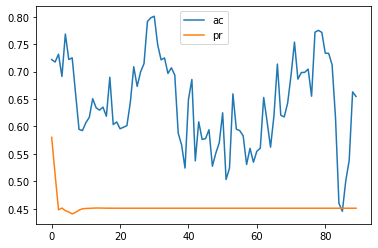

In [30]:
dd["ac"].plot()
dd["pr"].plot()
plt.legend(loc="best")

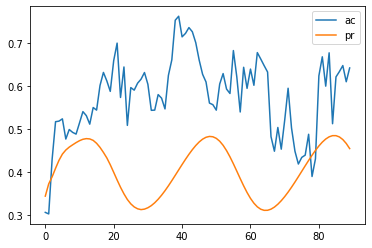

In [22]:
dd["ac"].plot()
dd["pr"].plot()
plt.legend(loc="best")

# ANN

In [80]:
uni_data

array([1.        , 1.        , 0.75      , 0.66666667, 0.25      ,
       0.65      , 0.20833333, 0.39285714, 0.8125    , 0.75      ,
       0.8       , 0.52272727, 0.70833333, 0.67307692, 0.5       ,
       0.5       , 0.40625   , 0.36764706, 0.27777778, 0.42105263,
       0.575     , 0.52380952, 0.42045455, 0.43478261, 0.375     ,
       0.53      , 0.48076923, 0.35185185, 0.60714286, 0.63793103,
       0.5       , 0.41935484, 0.640625  , 0.56060606, 0.44117647,
       0.60714286, 0.65277778, 0.71621622, 0.73684211, 0.70512821,
       0.6125    , 0.59756098, 0.35714286, 0.40697674, 0.39204545,
       0.42777778, 0.41304348, 0.30319149, 0.30729167, 0.30102041,
       0.29      , 0.2745098 , 0.29807692, 0.33490566, 0.33796296,
       0.29545455, 0.34375   , 0.40789474, 0.29741379, 0.33474576,
       0.2875    , 0.45901639, 0.51209677, 0.48412698, 0.60546875,
       0.51538462, 0.60984848, 0.63432836, 0.57352941, 0.69927536,
       0.7       , 0.6971831 , 0.73263889, 0.67465753, 0.73648

In [81]:
window_size = 10
batch_size = 1
shuffle_buffer_size = 20

In [82]:

dataset = tf.data.Dataset.from_tensor_slices(uni_data)
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.shuffle(shuffle_buffer_size)
dataset = dataset.batch(batch_size).prefetch(1)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[1.         0.75       0.66666667 0.25       0.65       0.20833333
  0.39285714 0.8125     0.75       0.8       ]] [0.52272727]
[[0.20833333 0.39285714 0.8125     0.75       0.8        0.52272727
  0.70833333 0.67307692 0.5        0.5       ]] [0.40625]
[[0.39285714 0.8125     0.75       0.8        0.52272727 0.70833333
  0.67307692 0.5        0.5        0.40625   ]] [0.36764706]
[[0.40625    0.36764706 0.27777778 0.42105263 0.575      0.52380952
  0.42045455 0.43478261 0.375      0.53      ]] [0.48076923]
[[0.575      0.52380952 0.42045455 0.43478261 0.375      0.53
  0.48076923 0.35185185 0.60714286 0.63793103]] [0.5]
[[0.43478261 0.375      0.53       0.48076923 0.35185185 0.60714286
  0.63793103 0.5        0.41935484 0.640625  ]] [0.56060606]
[[0.27777778 0.42105263 0.575      0.52380952 0.42045455 0.43478261
  0.375      0.53       0.48076923 0.35185185]] [0.60714286]
[[0.75       0.8        0.52272727 0.70833333 0.67307692 0.5
  0.5        0.40625    0.36764706 0.27777778]] [0.4

  0.59756098 0.35714286 0.40697674 0.39204545]] [0.42777778]
[[0.714      0.68055556 0.6476378  0.57617188 0.55620155 0.50961538
  0.47709924 0.41856061 0.62593985 0.70708955]] [0.71481481]
[[0.78333333 0.77122642 0.7546729  0.75462963 0.76605505 0.77045455
  0.7454955  0.74776786 0.72345133 0.75      ]] [0.70217391]
[[0.62593985 0.70708955 0.71481481 0.61580882 0.68248175 0.51811594
  0.60791367 0.59642857 0.58156028 0.62147887]] [0.56818182]
[[0.68055556 0.6476378  0.57617188 0.55620155 0.50961538 0.47709924
  0.41856061 0.62593985 0.70708955 0.71481481]] [0.61580882]
[[0.31388889 0.33241758 0.3451087  0.31989247 0.44680851 0.44473684
  0.4921875  0.62371134 0.58418367 0.7020202 ]] [0.6075]
[[0.60714286 0.63793103 0.5        0.41935484 0.640625   0.56060606
  0.44117647 0.60714286 0.65277778 0.71621622]] [0.73684211]
[[0.62147887 0.56818182 0.66493056 0.48275862 0.47945205 0.40816327
  0.55067568 0.43624161 0.51833333 0.4884106 ]] [0.53125]
[[0.47709924 0.41856061 0.62593985 0.707089

[[0.36645299 0.26382979 0.40995763 0.38080169 0.27310924 0.27405858
  0.396875   0.41182573 0.23657025 0.33847737]] [0.3647541]
[[0.35392157 0.53125    0.46789883 0.51356589 0.49420849 0.44423077
  0.42911877 0.37881679 0.34030418 0.28882576]] [0.24433962]
[[0.42911877 0.37881679 0.34030418 0.28882576 0.24433962 0.22838346
  0.20037453 0.30690299 0.17007435 0.2       ]] [0.18357934]
[[0.42224409 0.35392157 0.53125    0.46789883 0.51356589 0.49420849
  0.44423077 0.42911877 0.37881679 0.34030418]] [0.28882576]
[[0.43452381 0.44762846 0.42224409 0.35392157 0.53125    0.46789883
  0.51356589 0.49420849 0.44423077 0.42911877]] [0.37881679]
[[0.32019704 0.3125     0.34634146 0.4368932  0.48188406 0.46995192
  0.49043062 0.5452381  0.60781991 0.49292453]] [0.52230047]
[[0.27074236 0.25869565 0.39502165 0.37284483 0.33798283 0.36645299
  0.26382979 0.40995763 0.38080169 0.27310924]] [0.27405858]
[[0.46789883 0.51356589 0.49420849 0.44423077 0.42911877 0.37881679
  0.34030418 0.28882576 0.2443

In [47]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer="adam")
model.fit(dataset,epochs=50,verbose=1)

print("Layer weights {}".format(l0.get_weights()))

Epoch 1/50
306/306 [==============================] - 3s 10ms/step - loss: 0.0743
Epoch 2/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0480
Epoch 3/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0344
Epoch 4/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0261
Epoch 5/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0222
Epoch 6/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0178
Epoch 7/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0162
Epoch 8/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 9/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0140
Epoch 10/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0136
Epoch 11/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0126
Epoch 12/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0123
Epoch 13/50
306/306 [===

In [120]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5,input_shape=[window_size], activation='relu'),
    #tf.keras.layers.Dense(16, activation='relu'),
    #tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])


In [121]:
model.fit(dataset,epochs=40,verbose=1)

Epoch 1/40
346/346 [==============================] - 4s 12ms/step - loss: 0.0676 - mse: 0.0676 - mae: 0.1698
Epoch 2/40
346/346 [==============================] - 2s 5ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0959
Epoch 3/40
346/346 [==============================] - 1s 4ms/step - loss: 0.0146 - mse: 0.0145 - mae: 0.0911
Epoch 4/40
346/346 [==============================] - 1s 4ms/step - loss: 0.0119 - mse: 0.0118 - mae: 0.0834
Epoch 5/40
346/346 [==============================] - 1s 4ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0813
Epoch 6/40
346/346 [==============================] - 2s 4ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0801
Epoch 7/40
346/346 [==============================] - 2s 4ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0790
Epoch 8/40
346/346 [==============================] - 2s 5ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0776
Epoch 9/40
346/346 [==============================] - 2s 5ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0770
Epoch 10/40
346/34

In [122]:
current_data

array([0.4375    , 0.3907563 , 0.40293296, 0.40807799, 0.43333333,
       0.27908587, 0.24171271, 0.24862259, 0.28021978, 0.32465753])

In [123]:
def make_forecast(model,current_data,multi_step,past_history):
    pred_list=[]
    current_data=current_data.tolist()
    for _ in range(0,multi_step):
        data_forecast=np.reshape(current_data,(1,past_history))
        print(data_forecast)
        pred=model.predict(data_forecast)
        pred_list.append(pred)
        current_data.append(pred[0][0])
        current_data=current_data[-past_history:]        
    return pred_list

In [124]:
pre=make_forecast(model,current_data,90,univariate_past_history)

[[0.4375     0.3907563  0.40293296 0.40807799 0.43333333 0.27908587
  0.24171271 0.24862259 0.28021978 0.32465753]]
[[0.3907563  0.40293296 0.40807799 0.43333333 0.27908587 0.24171271
  0.24862259 0.28021978 0.32465753 0.28930968]]
[[0.40293296 0.40807799 0.43333333 0.27908587 0.24171271 0.24862259
  0.28021978 0.32465753 0.28930968 0.32117459]]
[[0.40807799 0.43333333 0.27908587 0.24171271 0.24862259 0.28021978
  0.32465753 0.28930968 0.32117459 0.35287988]]
[[0.43333333 0.27908587 0.24171271 0.24862259 0.28021978 0.32465753
  0.28930968 0.32117459 0.35287988 0.36647081]]
[[0.27908587 0.24171271 0.24862259 0.28021978 0.32465753 0.28930968
  0.32117459 0.35287988 0.36647081 0.36640567]]
[[0.24171271 0.24862259 0.28021978 0.32465753 0.28930968 0.32117459
  0.35287988 0.36647081 0.36640567 0.37612402]]
[[0.24862259 0.28021978 0.32465753 0.28930968 0.32117459 0.35287988
  0.36647081 0.36640567 0.37612402 0.39915961]]
[[0.28021978 0.32465753 0.28930968 0.32117459 0.35287988 0.36647081
  0.

[[0.4018597  0.40186936 0.40187925 0.4018889  0.40189707 0.40190327
  0.40190828 0.40191245 0.40191525 0.40191662]]
[[0.40186936 0.40187925 0.4018889  0.40189707 0.40190327 0.40190828
  0.40191245 0.40191525 0.40191662 0.40191704]]
[[0.40187925 0.4018889  0.40189707 0.40190327 0.40190828 0.40191245
  0.40191525 0.40191662 0.40191704 0.40191692]]
[[0.4018889  0.40189707 0.40190327 0.40190828 0.40191245 0.40191525
  0.40191662 0.40191704 0.40191692 0.4019162 ]]
[[0.40189707 0.40190327 0.40190828 0.40191245 0.40191525 0.40191662
  0.40191704 0.40191692 0.4019162  0.4019149 ]]
[[0.40190327 0.40190828 0.40191245 0.40191525 0.40191662 0.40191704
  0.40191692 0.4019162  0.4019149  0.4019133 ]]
[[0.40190828 0.40191245 0.40191525 0.40191662 0.40191704 0.40191692
  0.4019162  0.4019149  0.4019133  0.40191168]]
[[0.40191245 0.40191525 0.40191662 0.40191704 0.40191692 0.4019162
  0.4019149  0.4019133  0.40191168 0.40191007]]
[[0.40191525 0.40191662 0.40191704 0.40191692 0.4019162  0.4019149
  0.40

In [125]:
pre

[array([[0.28930968]], dtype=float32),
 array([[0.3211746]], dtype=float32),
 array([[0.35287988]], dtype=float32),
 array([[0.3664708]], dtype=float32),
 array([[0.36640567]], dtype=float32),
 array([[0.37612402]], dtype=float32),
 array([[0.3991596]], dtype=float32),
 array([[0.40848476]], dtype=float32),
 array([[0.41303617]], dtype=float32),
 array([[0.41144955]], dtype=float32),
 array([[0.42040694]], dtype=float32),
 array([[0.4249335]], dtype=float32),
 array([[0.42119575]], dtype=float32),
 array([[0.41903788]], dtype=float32),
 array([[0.41825873]], dtype=float32),
 array([[0.41860682]], dtype=float32),
 array([[0.41489452]], dtype=float32),
 array([[0.41102898]], dtype=float32),
 array([[0.40879834]], dtype=float32),
 array([[0.40760124]], dtype=float32),
 array([[0.4054622]], dtype=float32),
 array([[0.40254623]], dtype=float32),
 array([[0.40128666]], dtype=float32),
 array([[0.40062243]], dtype=float32),
 array([[0.39993012]], dtype=float32),
 array([[0.39896446]], dtype=f

In [96]:
last90forcompare

array([0.31557377, 0.39032698, 0.37024457, 0.33672087, 0.30810811,
       0.38207547, 0.3313172 , 0.30495979, 0.30080214, 0.42666667,
       0.51263298, 0.51525199, 0.5218254 , 0.47295515, 0.49671053,
       0.48818898, 0.48429319, 0.51174935, 0.5390625 , 0.52857143,
       0.50777202, 0.54844961, 0.54252577, 0.59447301, 0.62564103,
       0.60677749, 0.5809949 , 0.65394402, 0.69606599, 0.56772152,
       0.64141414, 0.50881612, 0.59610553, 0.58646617, 0.605625  ,
       0.61471322, 0.62748756, 0.60111663, 0.53836634, 0.53641975,
       0.57820197, 0.57063882, 0.54473039, 0.62408313, 0.66402439,
       0.75486618, 0.76456311, 0.71428571, 0.72041063, 0.7313253 ,
       0.72716346, 0.70203837, 0.66148325, 0.62768496, 0.61071429,
       0.55938242, 0.55390995, 0.54314421, 0.6067217 , 0.63352941,
       0.59624413, 0.58665105, 0.68341121, 0.62296037, 0.53953488,
       0.64733179, 0.59953704, 0.6426097 , 0.60426267, 0.67758621,
       0.66227064, 0.64759725, 0.63641553, 0.48234624, 0.45056

In [127]:
uni_df=pd.DataFrame({"data":uni_data})

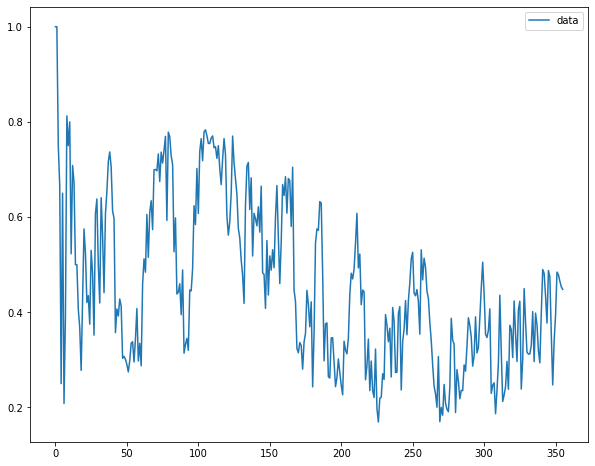

In [130]:
uni_df.plot(figsize=(10,8))

In [149]:
def Arima_model(train):
    model = ARIMA(train, order=(1, 1, 1))
    results_arima= model.fit(disp=False)
    #predictions_arima = model_fit_arima.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False)
    #r2_arima = r2_score(df[col_name].tail(length_of_test), predictions_arima.tail(length_of_test))
    return results_arima

In [140]:
def ARIMA_Prediction(df,col):
    model = ARIMA(df, order=(1, 1, 1))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(df), len(df), typ='levels')
    s = pd.Series(yhat,name=col)
    df2=s.to_frame()
    df=df.append(df2)
    return df

In [150]:
results_arima=Arima_model(uni_data)

In [151]:
ans=results_arima.forecast(steps=90)

In [170]:
ans[0]

array([0.6276569 , 0.62315889, 0.62161204, 0.62074034, 0.6200231 ,
       0.61934119, 0.61866737, 0.6179954 , 0.61732384, 0.61665239,
       0.61598096, 0.61530953, 0.6146381 , 0.61396668, 0.61329525,
       0.61262383, 0.6119524 , 0.61128098, 0.61060955, 0.60993812,
       0.6092667 , 0.60859527, 0.60792385, 0.60725242, 0.60658099,
       0.60590957, 0.60523814, 0.60456672, 0.60389529, 0.60322387,
       0.60255244, 0.60188101, 0.60120959, 0.60053816, 0.59986674,
       0.59919531, 0.59852389, 0.59785246, 0.59718103, 0.59650961,
       0.59583818, 0.59516676, 0.59449533, 0.5938239 , 0.59315248,
       0.59248105, 0.59180963, 0.5911382 , 0.59046678, 0.58979535,
       0.58912392, 0.5884525 , 0.58778107, 0.58710965, 0.58643822,
       0.5857668 , 0.58509537, 0.58442394, 0.58375252, 0.58308109,
       0.58240967, 0.58173824, 0.58106681, 0.58039539, 0.57972396,
       0.57905254, 0.57838111, 0.57770969, 0.57703826, 0.57636683,
       0.57569541, 0.57502398, 0.57435256, 0.57368113, 0.57300

In [169]:
last90

array([0.31557377, 0.39032698, 0.37024457, 0.33672087, 0.30810811,
       0.38207547, 0.3313172 , 0.30495979, 0.30080214, 0.42666667,
       0.51263298, 0.51525199, 0.5218254 , 0.47295515, 0.49671053,
       0.48818898, 0.48429319, 0.51174935, 0.5390625 , 0.52857143,
       0.50777202, 0.54844961, 0.54252577, 0.59447301, 0.62564103,
       0.60677749, 0.5809949 , 0.65394402, 0.69606599, 0.56772152,
       0.64141414, 0.50881612, 0.59610553, 0.58646617, 0.605625  ,
       0.61471322, 0.62748756, 0.60111663, 0.53836634, 0.53641975,
       0.57820197, 0.57063882, 0.54473039, 0.62408313, 0.66402439,
       0.75486618, 0.76456311, 0.71428571, 0.72041063, 0.7313253 ,
       0.72716346, 0.70203837, 0.66148325, 0.62768496, 0.61071429,
       0.55938242, 0.55390995, 0.54314421, 0.6067217 , 0.63352941,
       0.59624413, 0.58665105, 0.68341121, 0.62296037, 0.53953488,
       0.64733179, 0.59953704, 0.6426097 , 0.60426267, 0.67758621,
       0.66227064, 0.64759725, 0.63641553, 0.48234624, 0.45056

In [178]:
dd=pd.DataFrame({"actual":last90,"pred":ans[0]})

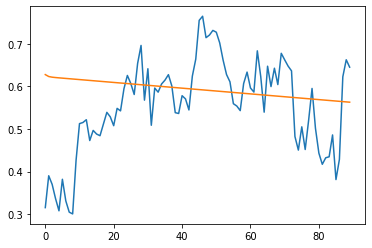

In [179]:
dd["actual"].plot()
dd["pred"].plot()

In [181]:
ans1=results_arima.predict(start=len(uni_data),end=len(uni_data)+len(last90))

In [182]:
ans1

array([-0.01476068, -0.00554099, -0.02507111, -0.00770015,  0.00520954,
        0.01048259, -0.01653055,  0.00562663,  0.01004491,  0.00589898,
       -0.03395883, -0.04306548, -0.02361872, -0.01467699,  0.00604068,
       -0.00427322, -0.00026338,  0.00047533, -0.00823363, -0.01271017,
       -0.00406911,  0.00340314, -0.01054903, -0.00427248, -0.01779921,
       -0.0187905 , -0.00479539,  0.0044715 , -0.01935367, -0.02277361,
        0.02488821, -0.00897758,  0.03327882, -0.00856784, -0.00216717,
       -0.00719824, -0.00688773, -0.00779563,  0.00308567,  0.01928081,
        0.01004913, -0.00742159, -0.00217462,  0.00586759, -0.02048649,
       -0.02272888, -0.03865355, -0.02338254,  0.00193252, -0.00129153,
       -0.00435314, -0.00156918,  0.00595451,  0.0143324 ,  0.01671915,
        0.01307726,  0.02115282,  0.01204281,  0.00885182, -0.01436345,
       -0.0157436 ,  0.00212765,  0.00336799, -0.02683145,  0.00309365,
        0.02528084, -0.01866427,  0.00366027, -0.01111022,  0.00